In [1]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
# Download real-time data for the stock (e.g., 'AAPL') for a specific date range
stock_data = yf.download('ADRO.JK', start='2024-01-01', end='2024-11-19')
real_prices = stock_data['Close'].values
print(real_prices)

[*********************100%***********************]  1 of 1 completed

[[2490.]
 [2410.]
 [2460.]
 [2440.]
 [2440.]
 [2430.]
 [2460.]
 [2450.]
 [2480.]
 [2510.]
 [2500.]
 [2490.]
 [2460.]
 [2430.]
 [2400.]
 [2350.]
 [2340.]
 [2360.]
 [2380.]
 [2400.]
 [2390.]
 [2400.]
 [2420.]
 [2420.]
 [2430.]
 [2460.]
 [2460.]
 [2470.]
 [2480.]
 [2510.]
 [2520.]
 [2430.]
 [2430.]
 [2420.]
 [2440.]
 [2420.]
 [2370.]
 [2380.]
 [2400.]
 [2420.]
 [2490.]
 [2540.]
 [2630.]
 [2670.]
 [2700.]
 [2670.]
 [2600.]
 [2670.]
 [2660.]
 [2630.]
 [2630.]
 [2650.]
 [2650.]
 [2650.]
 [2670.]
 [2740.]
 [2720.]
 [2700.]
 [2640.]
 [2690.]
 [2680.]
 [2690.]
 [2700.]
 [2810.]
 [2750.]
 [2730.]
 [2760.]
 [2750.]
 [2750.]
 [2680.]
 [2620.]
 [2600.]
 [2670.]
 [2710.]
 [2730.]
 [2730.]
 [2850.]
 [2810.]
 [2870.]
 [2950.]
 [2880.]
 [2830.]
 [2880.]
 [2880.]
 [2910.]
 [2880.]
 [2920.]
 [2870.]
 [2690.]
 [2680.]
 [2740.]
 [2770.]
 [2930.]
 [2920.]
 [2870.]
 [2850.]
 [2840.]
 [2750.]
 [2720.]
 [2790.]
 [2780.]
 [2780.]
 [2660.]
 [2730.]
 [2730.]
 [2720.]
 [2710.]
 [2750.]
 [2750.]
 [2790.]
 [2800.]
 

In [3]:
from tensorflow.keras.models import load_model

loaded_model = load_model("lstm_ADROJK_model.h5")


In [4]:
from sklearn.preprocessing import MinMaxScaler
window_size = 60 #high volatility
scaler = MinMaxScaler(feature_range=(0, 1))
# Prepare real-time stock data (use the same preprocessing as during training)
real_time_data = scaler.fit_transform(real_prices.reshape(-1, 1))  # Scale data if necessary
real_time_sequences = []  # Create sequences matching window_size

for i in range(len(real_time_data) - window_size):
    real_time_sequences.append(real_time_data[i:i + window_size])

real_time_sequences = np.array(real_time_sequences)
real_time_sequences = real_time_sequences.reshape(-1, window_size, 1)

# Predict
predicted_real_prices = loaded_model.predict(real_time_sequences)
predicted_real_prices = scaler.inverse_transform(predicted_real_prices)  # Reverse scaling


5/5 [==============================] - 2s 65ms/step


In [5]:
# Ensure the lengths of actual and predicted prices match
real_prices_trimmed = real_prices[window_size:]  # Trim to match prediction length

# MAPE Calculation
mape = np.mean(np.abs((real_prices_trimmed - predicted_real_prices.flatten()) / real_prices_trimmed)) * 100
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


Mean Absolute Percentage Error (MAPE): 14.82%


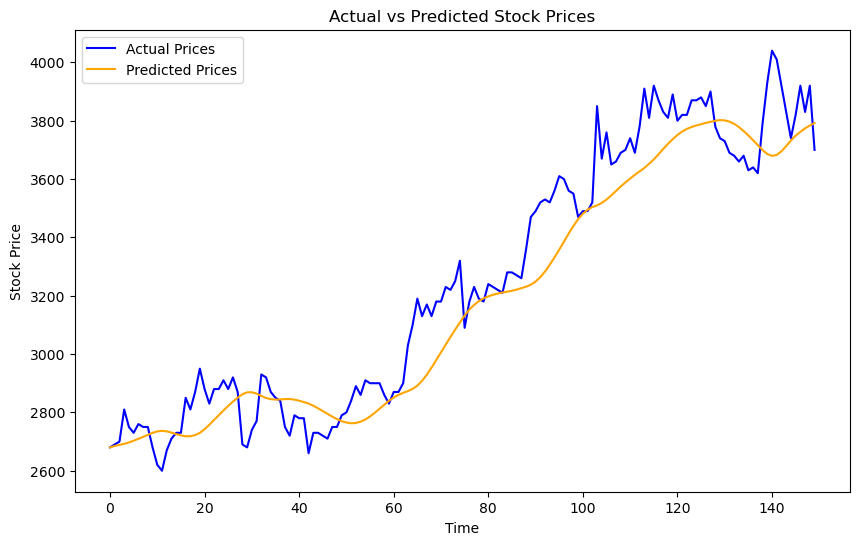

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(real_prices_trimmed, label="Actual Prices", color="blue")
plt.plot(predicted_real_prices, label="Predicted Prices", color="orange")
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [7]:
n_future_days = 90

# Take the last `window_size` data points from the scaled dataset
last_sequence = real_time_data[-window_size:]  # Assuming `real_time_data` is scaled
future_predictions = []

# Iteratively predict the next day
for _ in range(n_future_days):
    # Reshape the sequence to match the input shape: (1, window_size, 1)
    last_sequence_reshaped = last_sequence.reshape(1, window_size, 1)
    
    # Predict the next day
    next_prediction = loaded_model.predict(last_sequence_reshaped)
    
    # Store the prediction
    future_predictions.append(next_prediction[0, 0])  # Extract the scalar value
    
    # Append the prediction to the sequence and remove the first value to maintain window_size
    last_sequence = np.append(last_sequence[1:], next_prediction)

# Inverse transform the predictions to get the actual stock prices
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

print("Future Predictions for the Next 3 Months:")
print(future_predictions.flatten())


1/1 [==============================] - 0s 29ms/step
Future Predictions for the Next 3 Months:
[3796.5852 3797.7087 3796.2842 3793.0513 3788.629  3783.4907 3777.973
 3772.2998 3766.609  3760.9785 3755.446  3750.0251 3744.715  3739.5125
 3734.4067 3729.3936 3724.464  3719.6145 3714.8408 3710.1404 3705.5112
 3700.952  3696.4612 3692.0378 3687.68   3683.3887 3679.1604 3674.9958
 3670.892  3666.8494 3662.8657 3658.9395 3655.0703 3651.2563 3647.497
 3643.7905 3640.1362 3636.533  3632.9795 3629.4756 3626.0195 3622.6108
 3619.2476 3615.9302 3612.6572 3609.4272 3606.2412 3603.096  3599.9922
 3596.9282 3593.9043 3590.9185 3587.9717 3585.0625 3582.1904 3579.3547
 3576.5544 3573.7896 3571.058  3568.361  3565.6978 3563.0662 3560.4678
 3557.9001 3555.3635 3552.8584 3550.3823 3547.9368 3545.5195 3543.1318
 3540.7712 3538.439  3536.134  3533.8557 3531.6042 3529.3782 3527.1782
 3525.0037 3522.8535 3520.728  3518.627  3516.5493 3514.4954 3512.4639
 3510.4556 3508.469  3506.5054 3504.5627 3502.6418 3500.

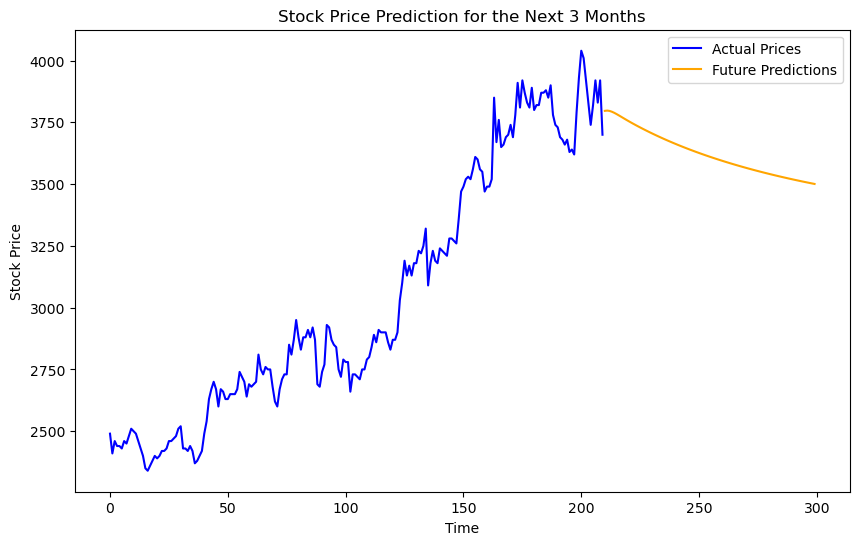

In [8]:
import matplotlib.pyplot as plt

# Create a time range for the predictions
prediction_days = np.arange(len(real_prices), len(real_prices) + n_future_days)

plt.figure(figsize=(10, 6))
plt.plot(real_prices, label="Actual Prices", color="blue")  # Historical prices
plt.plot(prediction_days, future_predictions, label="Future Predictions", color="orange")  # Predicted prices
plt.title("Stock Price Prediction for the Next 3 Months")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
